# Title

## Overview
The 2018 Kaggle Survey is a highly interesting dataset comprised of questions around many topics (e.g. tools used for Machine Learning and data analysis, industry, geography). This analysis attempts to outline patterns around gender pay gap. Not surprisingly, a considerable income discrepancy is found between genders and the research moves towards questioning whether this difference in income is justified.

## Data Preparation
For this analysis, some of the data points have been manipulated respective to the original dataset. These are:
- **Gender**: only the samples where the person who filled the survey declared being either a man or a woman have been kept.
- **Range data**: dimensions such as income, age or experience (e.g. in current role, coding) came mostly in two flavours: 1) as ranges (e.g. 30-34 years), in these cases an average was made between the two (e.g. 32 years); and 2) as a number with a "+" sign meaning *more than* (e.g. $500,000+), in these cases just the number was kept (e.g. 500,000).
- When considered appropriate, data has been deliberately left out in certain visualizations with the aim of better represent the reality. For instance, when showing *average income by age*, only data points that represented 50 or more respondents were included.

In [66]:
# data preparation

import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import FormatStrFormatter

plt.style.use('fivethirtyeight')
%matplotlib inline

# multiple_choice = pd.read_csv('../input/multipleChoiceResponses.csv', low_memory=False)
multiple_choice = pd.read_csv('kaggle-survey-2018/multipleChoiceResponses.csv', low_memory=False)

def convert_salary(salary):

    if salary == '500,000+':
        return 500000
    else:
        try:
            a, b = salary.replace(',','').split('-')
            avg = (int(a)*1000+int(b))/2
            return avg
        except:
            return None

def convert_xp(xp, return_type):
    if xp == '30 +':
        xp = 30
    elif xp == '40+ years':
        xp = 40
    elif xp == '< 1 year':
        xp = 0.5
    else:
        try:
            a, b = xp.replace(' years', '').split('-')
            xp = (int(a)+int(b))/2
        except:
            return None
        
    if return_type == 'years':
        return xp
    elif return_type == 'seniority level':
        if xp < 3:
            return 0
        elif xp < 6:
            return 1
        else:
            return 2
    else:
        return None   

def convert_age(age):
    if age == '80+':
        return 80
    else:
        try:
            a, b = age.split('-')
            return (int(a)+int(b))/2
        except:
            return None

def convert_ind_projects(response):

    if response == 'Independent projects are much less important than academic achievements':
        return 0
    elif response == 'Independent projects are slightly less important than academic achievements':
        return 1
    elif response == 'Independent projects are equally important as academic achievements':
        return 2
    elif response == 'Independent projects are slightly more important than academic achievements':
        return 3
    elif response == 'Independent projects are much more important than academic achievements':
        return 4
    else:
        return None

def importance_scale(response):

    if response == 'Not at all important':
        return 0
    elif response == 'Slightly important':
        return 1
    elif response == 'Very important':
        return 2
    else:
        return None

df = pd.DataFrame()
df['gender'] = multiple_choice.Q1[1:]
df['current_role_xp'] = multiple_choice.Q8[1:].apply(convert_xp, args = ('years',))
df['coding_xp'] = multiple_choice.Q24[1:].apply(convert_xp, args = ('years',))
df['ml_xp'] = multiple_choice.Q25[1:].apply(convert_xp, args = ('years',))
df['current_role_xp_level'] = multiple_choice.Q8[1:].apply(convert_xp, args = ('seniority level',))
df['coding_xp_level'] = multiple_choice.Q24[1:].apply(convert_xp, args = ('seniority level',))
df['ml_xp_level'] = multiple_choice.Q25[1:].apply(convert_xp, args = ('seniority level',))
df['income'] = multiple_choice.Q9[1:].apply(convert_salary)
df['geography'] = multiple_choice.Q3[1:]
df['original_age'] = multiple_choice.Q2[1:]
df['age'] = multiple_choice.Q2[1:].apply(convert_age)
df['ind_projects_importance'] = multiple_choice.Q40[1:].apply(convert_ind_projects)
df['ml_fairness'] = multiple_choice.Q41_Part_1[1:].apply(importance_scale)
df['ml_explainability'] = multiple_choice.Q41_Part_2[1:].apply(importance_scale)
df['ml_reproducibility'] = multiple_choice.Q41_Part_3[1:].apply(importance_scale)
df['title'] = multiple_choice.Q6[1:]
df['industry'] = multiple_choice.Q7[1:]

df = df[df.gender.isin(['Male', 'Female'])]

fig_height = [10, 15]
fig_width = [20, 20]
title_fontsize = [20, 35]
axis_labels_fontsize = [10, 20]
tick_fontsize = [15, 20]

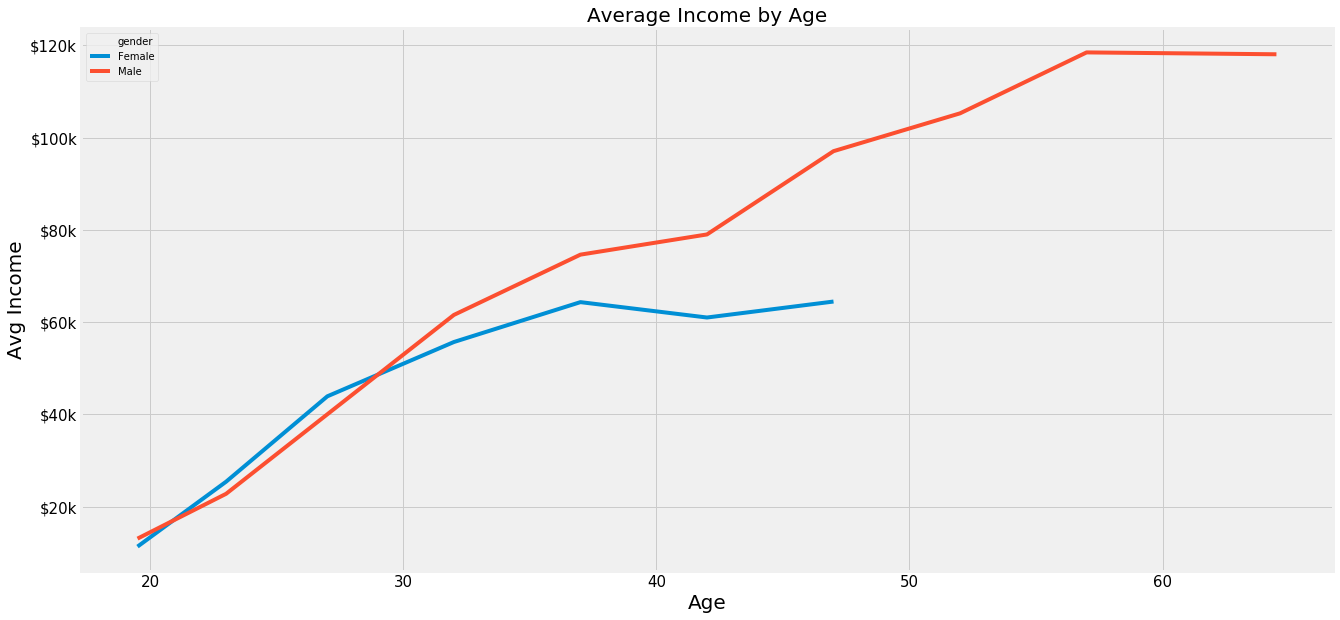

In [69]:
df_plot = sqldf("""
with bd as (
    select gender, age, avg(income)*1.0/1000 as income_mean, sum(case when income is not null then 1 else 0 end) as income_count
    from df
    group by 1, 2
)
, fl as (
    select *
    from bd
    where gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from bd
    where gender = 'Male'
    and income_count >= 50
)
, ages as (
    select distinct fl.age
    from fl
    join ml on fl.age = ml.age
)
select *
from fl
--where age in (select * from ages)
UNION ALL
select *
from ml
--where age in (select * from ages)
""")


plt.subplots(figsize=(fig_width[0],fig_height[0]))
c1 = sns.lineplot(x = 'age', y='income_mean', hue='gender', data=df_plot)
c1.set_title('Average Income by Age', fontsize=title_fontsize[0])
c1.set_xlabel('Age', fontsize=axis_labels_fontsize[1])
c1.set_ylabel('Avg Income', fontsize=axis_labels_fontsize[1])
c1.yaxis.set_major_formatter(FormatStrFormatter('$%.0fk'))
c1.tick_params(labelsize=tick_fontsize[0])

In [ ]:
df_plot = sqldf("""
select title, gender, avg(income) as income_mean
from df
where age > 42 and gender = 'Male' and title is not null and income is not null and title != 'Other'
group by 1, 2
order by avg(income) desc
limit 10
""")

fig, axs = plt.subplots(ncols=2, figsize=(32, 16))
sns.barplot(x='income_mean', y='title', hue = 'gender', data=df_plot, ax=axs[1])
plt.show()

df_plot = sqldf("""
with high_paying_titles as (
    select title, avg(income) as income_mean
    from df
    where age > 42 and gender = 'Male' and title is not null and income is not null and title != 'Other'
    group by 1
    order by avg(income) desc
    limit 10
)
, total_counts as (
    select gender, count(*) as gender_count
    from df
    where title is not null
    group by 1
)
select df.title, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.title in (select title from high_paying_titles)
group by 1, 2, 3
UNION ALL
select df.title, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.title in (select title from high_paying_titles)
group by 1, 2, 3
""")

sns.barplot(x='gender_perc', y='title', hue='gender', data=df_plot.sort_values(by='gender_perc', ascending = False))
plt.show()

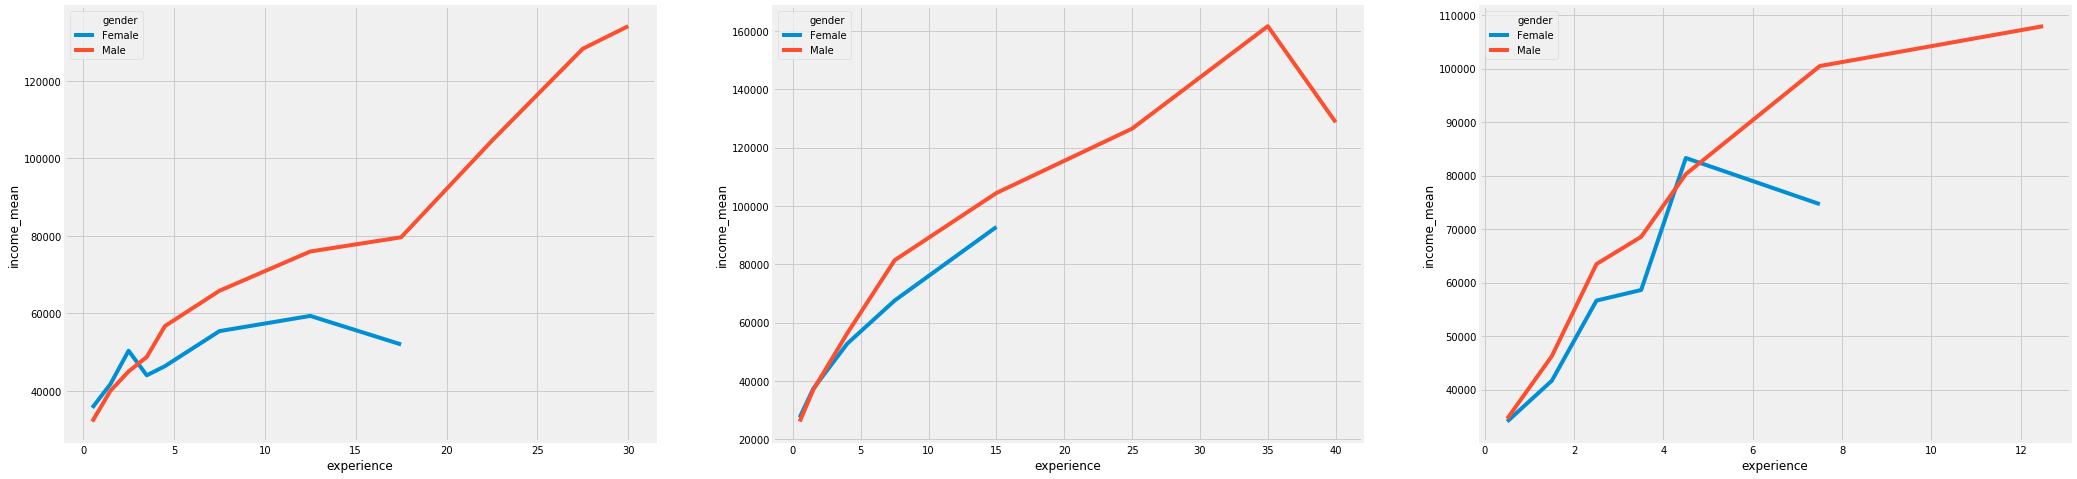

In [103]:
df_plot = sqldf("""
select gender, current_role_xp as experience, 'current_role_xp' as dimension, avg(income) as income_mean,  count(*) as population
from df
where current_role_xp is not null
group by 1, 2, 3
UNION ALL
select gender, coding_xp as experience, 'coding_xp' as dimension, avg(income) as income_mean,  count(*) as population
from df
where coding_xp is not null
group by 1, 2, 3
UNION ALL
select gender, ml_xp as experience, 'ml_xp' as dimension, avg(income) as income_mean,  count(*) as population
from df
where ml_xp is not null
group by 1, 2, 3
""")

df_plot = df_plot[df_plot['population']>=50]

fig, axs = plt.subplots(ncols=3, figsize=(32, 8))
sns.lineplot(x = 'experience', y='income_mean', hue='gender', data=df_plot[df_plot['dimension']=='current_role_xp'], ax=axs[0])
sns.lineplot(x = 'experience', y='income_mean', hue='gender', data=df_plot[df_plot['dimension']=='coding_xp'], ax=axs[1])
sns.lineplot(x = 'experience', y='income_mean', hue='gender', data=df_plot[df_plot['dimension']=='ml_xp'], ax=axs[2])
plt.show()


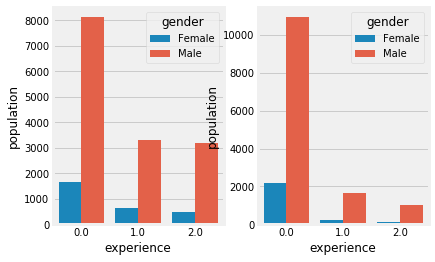

In [11]:
df_plot = sqldf("""
select gender, coding_xp_level as experience, 'coding_xp' as dimension, count(*) as population
from df
where coding_xp_level is not null
group by 1, 2
UNION ALL
select gender, ml_xp_level as experience, 'ml_xp' as dimension, count(*) as population
from df
where ml_xp_level is not null
group by 1, 2
""")

fix, axs = plt.subplots(ncols=2)
sns.barplot(x='experience', y='population', hue='gender', data=df_plot[df_plot['dimension']=='coding_xp'], ax=axs[0])
sns.barplot(x='experience', y='population', hue='gender', data=df_plot[df_plot['dimension']=='ml_xp'], ax=axs[1])
plt.show()

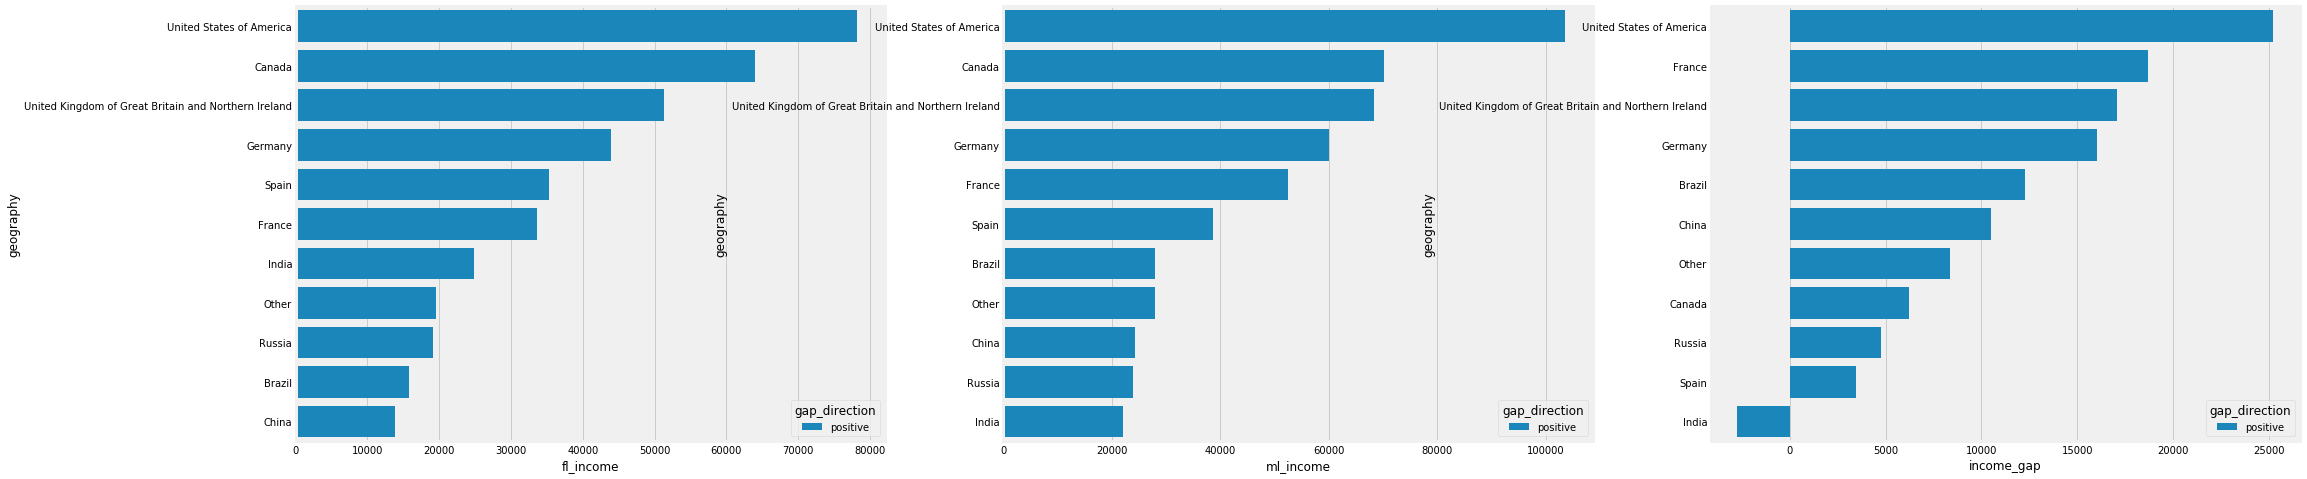

In [12]:
df_plot = sqldf("""
with bd as (
    select gender, geography, avg(income) as income_mean, sum(case when income is not null then 1 else 0 end) as income_count
    from df
    group by 1, 2
)
, fl as (
    select *
    from bd
    where gender = 'Female'
    and income_count >= 50
)
, ml as (
    select *
    from bd
    where gender = 'Male'
    and income_count >= 50
)
, geos as (
    select distinct fl.geography
    from fl
    join ml on fl.geography = ml.geography
)
select fl.geography, fl.income_mean as fl_income, ml.income_mean as ml_income, (ml.income_mean-fl.income_mean) as income_gap, case when (ml.income_mean-fl.income_mean) > 0 then 'positive' else 'positive' end as gap_direction
from fl
join ml on fl.geography = ml.geography
where fl.geography in (select * from geos)
order by (ml.income_mean-fl.income_mean) desc
"""
)


fig, axs = plt.subplots(ncols=3, figsize=(32, 8))
sns.barplot(x='fl_income', y='geography', hue='gap_direction', data=df_plot.sort_values(by='fl_income', ascending = False), ax=axs[0])
sns.barplot(x='ml_income', y='geography', hue='gap_direction', data=df_plot.sort_values(by='ml_income', ascending = False), ax=axs[1])
sns.barplot(x='income_gap', y='geography', hue='gap_direction', data=df_plot.sort_values(by='income_gap', ascending = False), ax=axs[2])
plt.show()

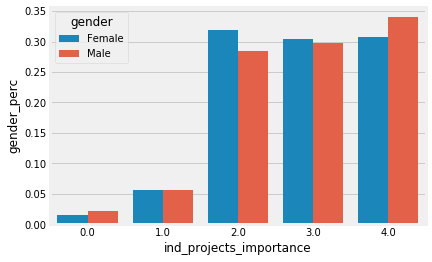

In [15]:
df_plot = sqldf("""
with total_counts as (
    select gender, count(*) as gender_count
    from df
    where ind_projects_importance is not null
    group by 1
)
select df.ind_projects_importance, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.ind_projects_importance is not null
group by 1, 2, 3
UNION ALL
select df.ind_projects_importance, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.ind_projects_importance is not null
group by 1, 2, 3
""")

sns.barplot(x='ind_projects_importance', y='gender_perc', hue='gender', data=df_plot.sort_values(by='ind_projects_importance'))
plt.show()

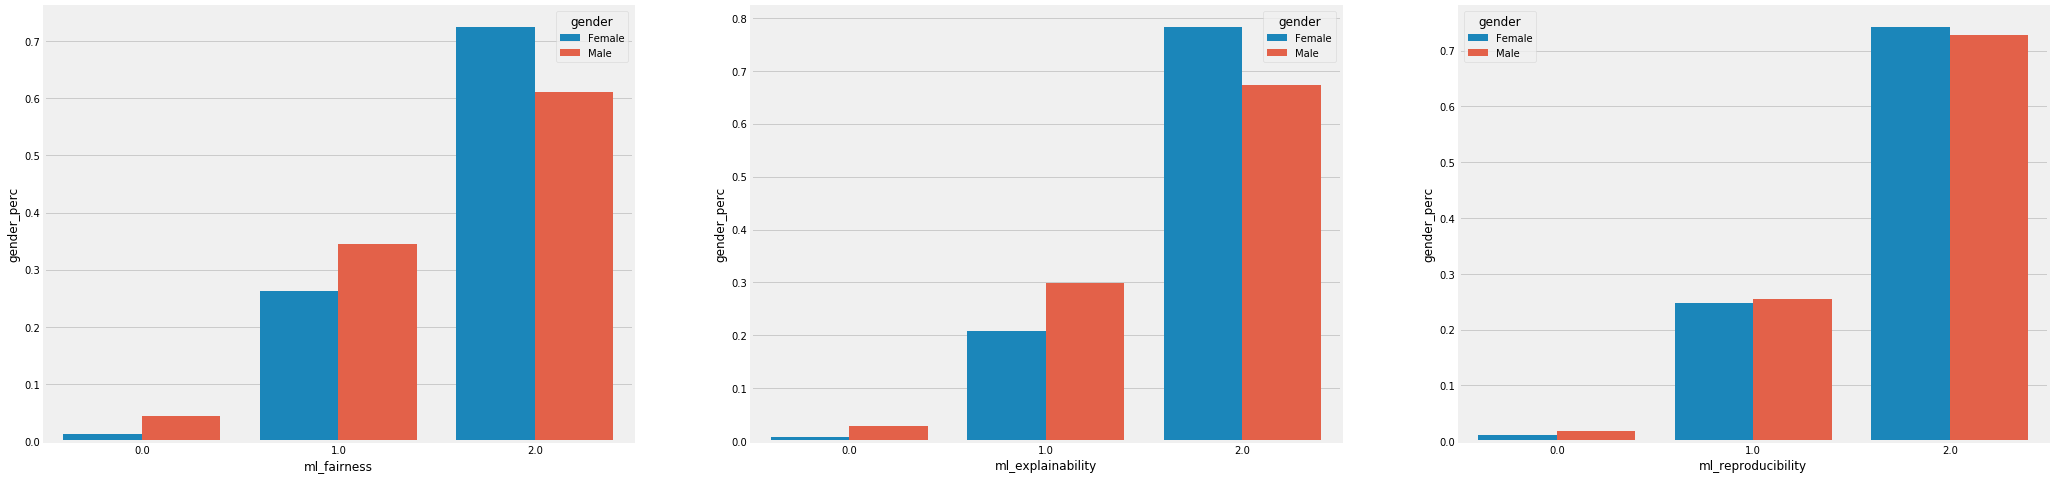

In [106]:
df_plot = sqldf("""
with total_counts as (
    select gender, count(*) as gender_count
    from df
    where ml_fairness is not null
    group by 1
)
select df.ml_fairness, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.ml_fairness is not null
group by 1, 2, 3
UNION ALL
select df.ml_fairness, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.ml_fairness is not null
group by 1, 2, 3
""")

fig, axs = plt.subplots(ncols=3, figsize=(32, 8))

sns.barplot(x='ml_fairness', y='gender_perc', hue='gender', data=df_plot.sort_values(by='ml_fairness'), ax = axs[0])

df_plot = sqldf("""
with total_counts as (
    select gender, count(*) as gender_count
    from df
    where ml_explainability is not null
    group by 1
)
select df.ml_explainability, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.ml_explainability is not null
group by 1, 2, 3
UNION ALL
select df.ml_explainability, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.ml_explainability is not null
group by 1, 2, 3
""")

sns.barplot(x='ml_explainability', y='gender_perc', hue='gender', data=df_plot.sort_values(by='ml_explainability'), ax = axs[1])

df_plot = sqldf("""
with total_counts as (
    select gender, count(*) as gender_count
    from df
    where ml_reproducibility is not null
    group by 1
)
select df.ml_reproducibility, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.ml_reproducibility is not null
group by 1, 2, 3
UNION ALL
select df.ml_reproducibility, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.ml_reproducibility is not null
group by 1, 2, 3
""")

sns.barplot(x='ml_reproducibility', y='gender_perc', hue='gender', data=df_plot.sort_values(by='ml_reproducibility'), ax = axs[2])


plt.show()

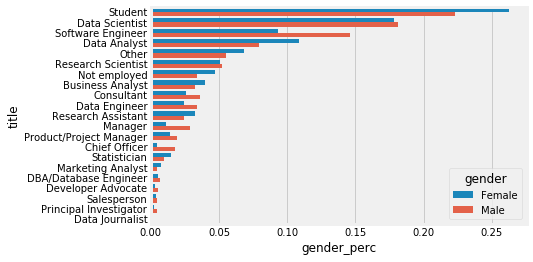

In [38]:
df_plot = sqldf("""
with total_counts as (
    select gender, count(*) as gender_count
    from df
    where title is not null
    group by 1
)
select df.title, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.title is not null
group by 1, 2, 3
UNION ALL
select df.title, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.title is not null
group by 1, 2, 3
""")

sns.barplot(x='gender_perc', y='title', hue='gender', data=df_plot.sort_values(by='gender_perc', ascending = False))
plt.show()

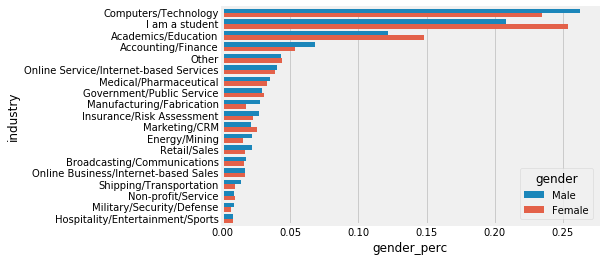

In [46]:
df_plot = sqldf("""
with total_counts as (
    select gender, count(*) as gender_count
    from df
    where industry is not null
    group by 1
)
select df.industry, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Female' and df.industry is not null
group by 1, 2, 3
UNION ALL
select df.industry, df.gender, tc.gender_count, count(*), count(*)*1.0/tc.gender_count as gender_perc
from df
join total_counts tc on df.gender = tc.gender
where df.gender = 'Male' and df.industry is not null
group by 1, 2, 3
""")

sns.barplot(x='gender_perc', y='industry', hue='gender', data=df_plot.sort_values(by='gender_perc', ascending = False))
plt.show()